# Multi-Modal Retrieval using GPT text embedding and CLIP image embedding for Wikipedia Articles

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex.

Wikipedia Text embedding index: GPT text embeddings from OpenAI
Wikipedia Imges embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI
Query encoder:
* Encoder query text for text index using GPT embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/openai/CLIP)

Steps:
1. Download texts and images raw files for Wikipedia articles
2. Build text index for vector store using GPT embeddings
3. Build image index for vector store using CLIP embeddings
4. Retrieval text index and image index simultaneously using different query encoding embeddings

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/openai/CLIP.git to /private/var/folders/5y/jz94hdjn3cx9vc2100gsbqb40000gn/T/pip-req-build-z0uvxi1_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/5y/jz94hdjn3cx9vc2100gsbqb40000gn/T/pip-req-build-z0uvxi1_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

## Load and initialize CLIP model

In [ ]:
import torch
import clip
import numpy as np

model, preprocess = clip.load("ViT-B/32")
# model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Load and Download Multi-Model datasets including texts and images from Wikipedia
Parse wikipedia articles and save into local folder

In [ ]:
from pathlib import Path
import requests

wiki_titles = [
    "batman",
    "Vincent van Gogh",
    "San Francisco",
    "iPhone",
    "Tesla Model S",
    "deep learning",
    "BTS",
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

## Build Vector Store using GPT embeddings for Wikipedia text under collection `wikipedia_text`

In [ ]:
import qdrant_client
from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext

text_client = qdrant_client.QdrantClient(location=":memory:")
# load Text documents from the directory
text_documents = SimpleDirectoryReader("./data_wiki").load_data()

service_context = ServiceContext.from_defaults()
text_vector_store = QdrantVectorStore(
    client=text_client, collection_name="wikipedia_text"
)
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)
wiki_text_index = VectorStoreIndex.from_documents(
    text_documents,
    storage_context=storage_context,
    service_context=service_context,
)

In [ ]:
text_query_engine = wiki_text_index.as_query_engine()
text_wiki_index_response = text_query_engine.query("who are BTS team members")
print(text_wiki_index_response)

BTS team members include Jin, Suga, J-Hope, RM, Jimin, V, and Jungkook.


## Download and store imges from Wiki Pages 

In [ ]:
import wikipedia
import urllib.request

image_path = Path("images_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 15

wiki_titles = [
    "batman",
    "Vincent van Gogh",
    "San Francisco",
    "iPhone",
    "Tesla Model S",
    "deep learning",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        # raise Exception("No page found")
        continue

batman
Vincent van Gogh
San Francisco
iPhone
Tesla Model S
deep learning
BTS band


### Show downloaded Wiki Images

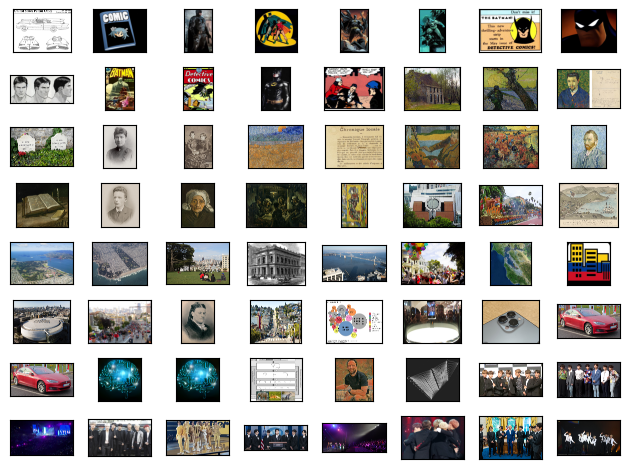

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Generate Clip embeddings for each each image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, preprocess = clip.load("ViT-B/32", device=device)
print(clip.available_models())

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}
with torch.no_grad():
    for image_id in image_metadata_dict:
        img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )
            image_features = model.encode_image(image)
            img_emb_dict[image_id] = image_features

cpu
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


### Build a separate CLIP image embedding index using a different collection name

In [ ]:
from llama_index.schema import ImageDocument

img_documents = []
for image_id in image_metadata_dict:
    if image_id in img_emb_dict:
        filename = image_metadata_dict[image_id]["filename"]
        filepath = image_metadata_dict[image_id]["img_path"]
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )
        newImgDoc.embedding = img_emb_dict[image_id].tolist()[0]
        img_documents.append(newImgDoc)


img_client = qdrant_client.QdrantClient(location=":memory:")

service_context = ServiceContext.from_defaults()
image_vector_store = QdrantVectorStore(
    client=img_client, collection_name="wikipedia_img"
)
storage_context = StorageContext.from_defaults(vector_store=image_vector_store)
image_index = VectorStoreIndex.from_documents(
    img_documents,
    storage_context=storage_context,
    service_context=service_context,
)
# print(image_index)

In [ ]:
from llama_index.vector_stores import VectorStoreQuery


def retrieve_results_from_image_index(test_query):
    # query_engine = image_index.as_query_engine()
    # test_query = 'who are BTS team members'
    text = clip.tokenize(test_query).to(device)
    query_embedding = model.encode_text(text).tolist()[0]
    # print(text_features.tolist()[0])

    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=5,
        mode="default",
    )

    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results

In [ ]:
def plot_image_retrieve_results(image_retrieval_results):
    plt.figure(figsize=(16, 5))

    img_cnt = 0
    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        # plt.title(f"{filename}\n{descriptions[name]}")
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [ ]:
## Get MultiModal retrieval results for a example query

Text retrieval results: 
BTS team members include Jin, Suga, J-Hope, RM, Jimin, V, and Jungkook.


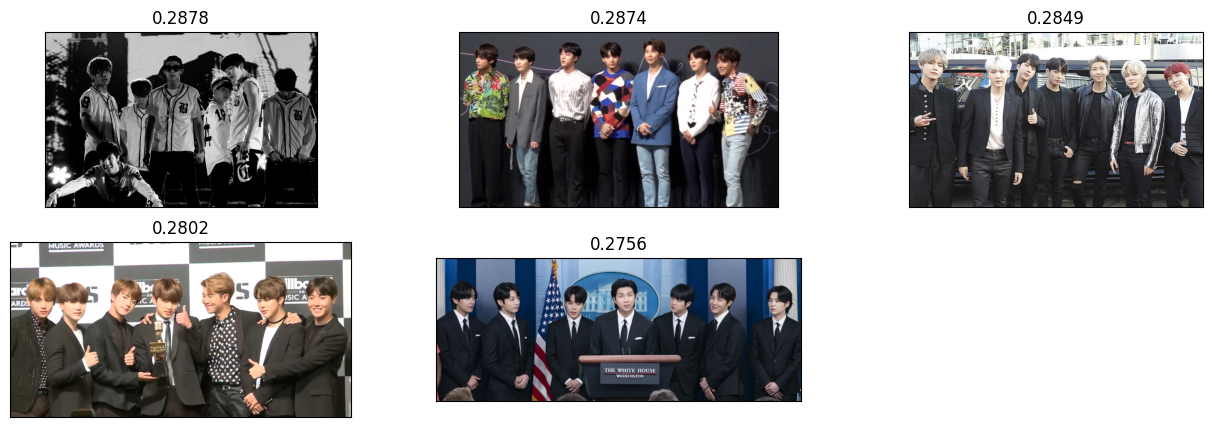

In [ ]:
test_query = "who are BTS team members"
# generate Image retrieval results
image_retrieval_results = retrieve_results_from_image_index(test_query)
plot_image_retrieve_results(image_retrieval_results)

# generate Text retrieval results
text_query_engine = wiki_text_index.as_query_engine()
text_retrieval_results = text_query_engine.query(test_query)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
Vincent van Gogh is famous for his paintings of various subjects, including landscapes, still lifes, portraits, and self-portraits. Some of his most well-known paintings include "Sunflowers," "Starry Night," "Irises," "The Potato Eaters," and "Self-Portrait with Bandaged Ear." These paintings are characterized by bold, symbolic colors, dramatic brushwork, and expressive style, which contributed to the foundations of modern art.


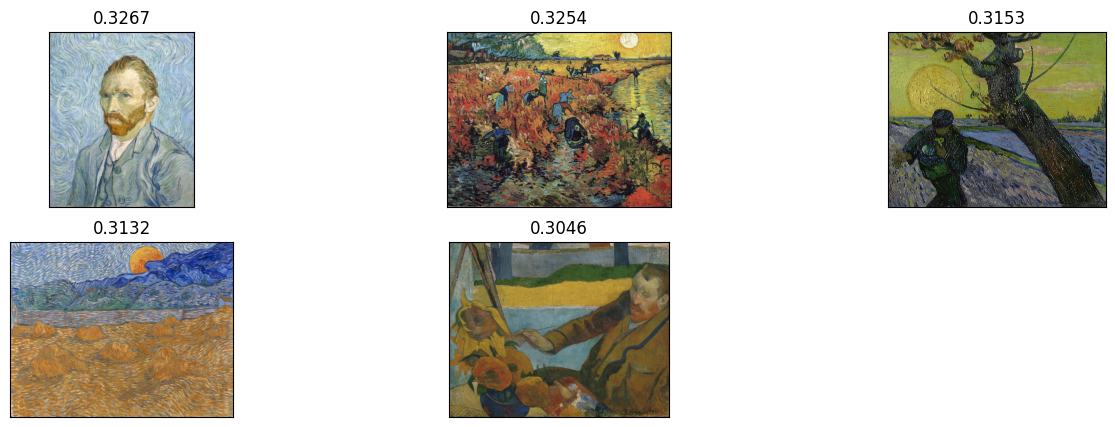

In [ ]:
test_query = "what are Vincent van Gogh's famous paintings"
# generate Image retrieval results
image_retrieval_results = retrieve_results_from_image_index(test_query)
plot_image_retrieve_results(image_retrieval_results)

# generate Text retrieval results
text_query_engine = wiki_text_index.as_query_engine()
text_retrieval_results = text_query_engine.query(test_query)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
The popular tourist attractions in San Francisco include the Golden Gate Bridge, Alamo Square Park, Lombard Street, Pier 39, and Alcatraz Island.


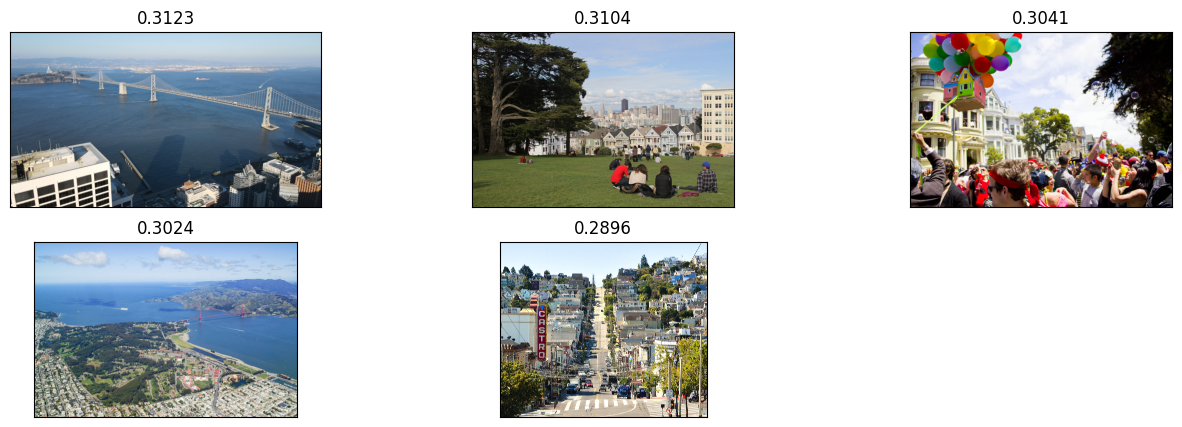

In [ ]:
test_query = "what is the popular tourist attraction in San Francisco"
# generate Image retrieval results
image_retrieval_results = retrieve_results_from_image_index(test_query)
plot_image_retrieve_results(image_retrieval_results)

# generate Text retrieval results
text_query_engine = wiki_text_index.as_query_engine()
text_retrieval_results = text_query_engine.query(test_query)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
Tesla, Inc. makes Tesla vehicles.


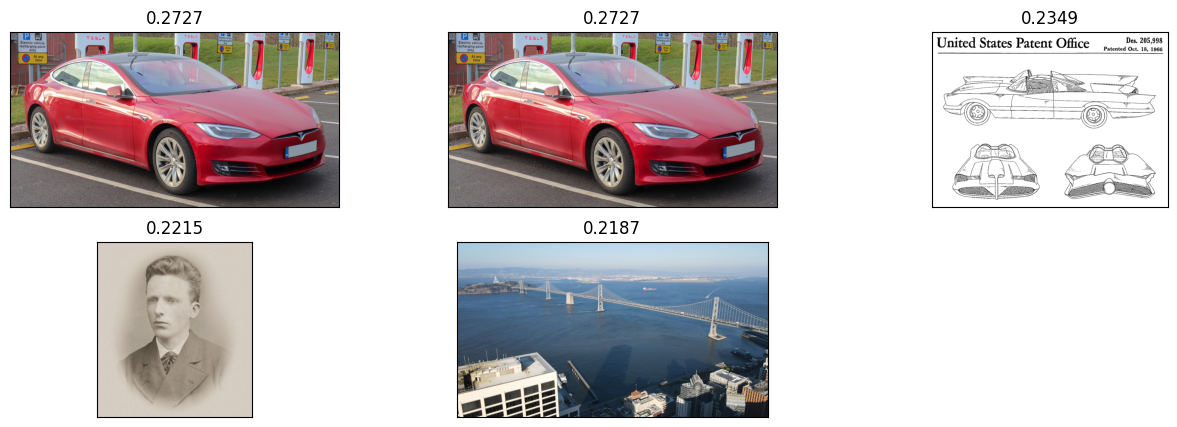

In [ ]:
test_query = "which company makes Tesla"
# generate Image retrieval results
image_retrieval_results = retrieve_results_from_image_index(test_query)
plot_image_retrieve_results(image_retrieval_results)

# generate Text retrieval results
text_query_engine = wiki_text_index.as_query_engine()
text_retrieval_results = text_query_engine.query(test_query)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
The main character in Batman is Bruce Wayne, who assumes the alter ego of Batman.


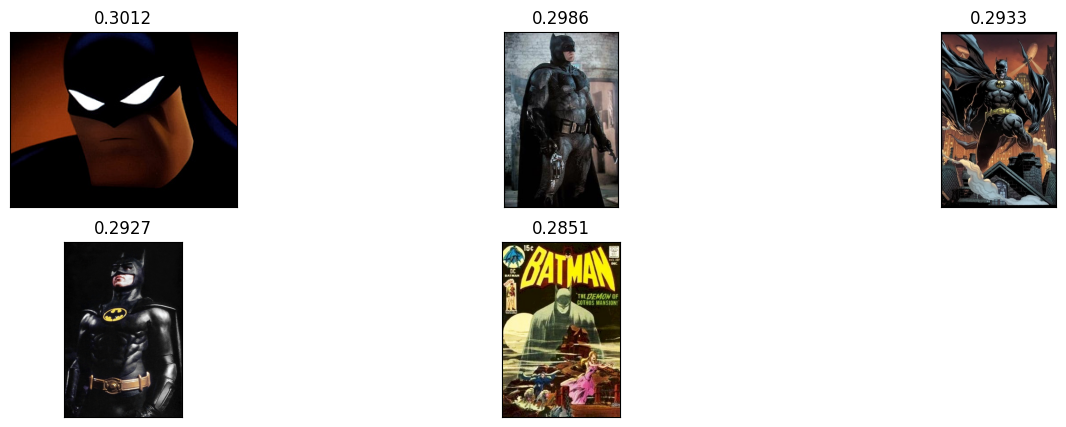

In [ ]:
test_query = "what is the main character in Batman"
# generate Image retrieval results
image_retrieval_results = retrieve_results_from_image_index(test_query)
plot_image_retrieve_results(image_retrieval_results)

# generate Text retrieval results
text_query_engine = wiki_text_index.as_query_engine()
text_retrieval_results = text_query_engine.query(test_query)
print("Text retrieval results: \n" + str(text_retrieval_results))